In [1]:
import json 
import os 

import pandas as pd 
import numpy as np
import datetime as dt

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from dateutil.parser import parse



import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

sns.set()
pd.set_option('display.max_colwidth', None)

# IMPORT AND PREPROCESS

In [2]:
import requests as r 

def retrieve_dataset(series:str, frequency:str, area:str, indicator:str, unit:str):
    """
    This function retrieves data from IMF dataservices API
    
    series: The series code 
    frequency: The dataset frequency
    area: The data region
    indicator: The Indicator code
    unit: The data measurement unit
    """

    url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
    key = f'CompactData/{series}/{frequency}.{area}.{indicator}.{unit}'
    
    data = r.get(f'{url}{key}').json()
    
    tmp = data['CompactData']['DataSet']['Series']

    df = pd.DataFrame({tmp['@COMMODITY'] : {pd.to_datetime(i['@TIME_PERIOD']) : 
         round(float(i['@OBS_VALUE']), 2) for i in tmp['Obs']}})
       
    return df 

copper_ = {
    'series': "PCPS",
    'frequency': "M",
    'area': "W00",
    'indicator': "PCOPP",
    'unit': "USD"
}

oil_ = {
    'series': "PCPS",
    'frequency': "M",
    'area': "W00",
    'indicator': "POILBRE",
    'unit': "USD"
}


df_copper = retrieve_dataset(copper_['series'],
                             copper_['frequency'],
                             copper_['area'],
                             copper_['indicator'],
                             copper_['unit'])

df_oil = retrieve_dataset(oil_['series'],
                             oil_['frequency'],
                             oil_['area'],
                             oil_['indicator'],
                             oil_['unit'])

print('\nCOPPER')
print(df_copper.info())

print('\nOIL')
print(df_oil.info())


COPPER
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 371 entries, 1990-01-01 to 2020-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PCOPP   371 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB
None

OIL
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 371 entries, 1990-01-01 to 2020-11-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   POILBRE  371 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB
None


In [3]:
#COPPER

df_copper.head()

PCOPP
1990-01-01  2365.56
1990-02-01  2358.94
1990-03-01  2625.70
1990-04-01  2685.23
1990-05-01  2740.34

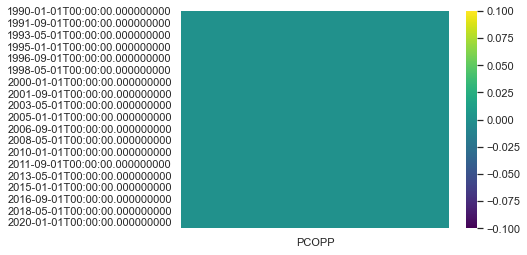

In [4]:
#cheking for nulls 
sns.heatmap(df_copper.isnull(), cmap='viridis')

In [5]:
#OIL

df_oil.head()


POILBRE
1990-01-01    21.25
1990-02-01    19.93
1990-03-01    18.37
1990-04-01    16.49
1990-05-01    16.34

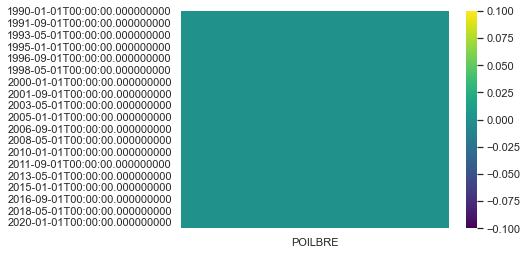

In [6]:
#cheking for nulls 
sns.heatmap(df_oil.isnull(), cmap='viridis')

In [7]:
df = pd.merge(df_copper, df_oil, how='inner', right_index=True, left_index=True)

col_map = {
    "PCOPP": 'COPPER_USD_TON',
    "POILBRE": 'BRENT_OIL_USD_BLL'
}

df = df.rename(columns=col_map)

df.head()

COPPER_USD_TON  BRENT_OIL_USD_BLL
1990-01-01         2365.56              21.25
1990-02-01         2358.94              19.93
1990-03-01         2625.70              18.37
1990-04-01         2685.23              16.49
1990-05-01         2740.34              16.34

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 371 entries, 1990-01-01 to 2020-11-01
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   COPPER_USD_TON     371 non-null    float64
 1   BRENT_OIL_USD_BLL  371 non-null    float64
dtypes: float64(2)
memory usage: 8.7 KB
None


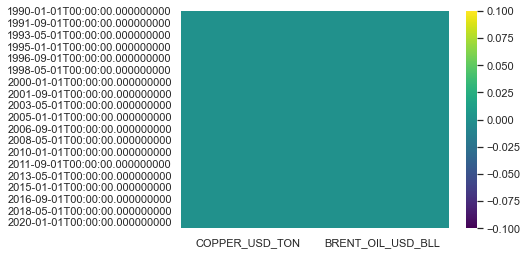

In [8]:
print(df.info())

sns.heatmap(df.isnull(), cmap='viridis')

# Search for trend and seasonal behaviors

In [9]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df.index,
    y=df.COPPER_USD_TON
                        ))

fig.update_layout(legend_title_text = "COPPER_USD_TON")
fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="USD per TON")

fig.show()


In [10]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df.index,
    y=df.BRENT_OIL_USD_BLL
                        ))

fig.update_layout(legend_title_text = "BRENT_OIL_USD_BLL")
fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="USD per BARELL")

fig.show()


[]

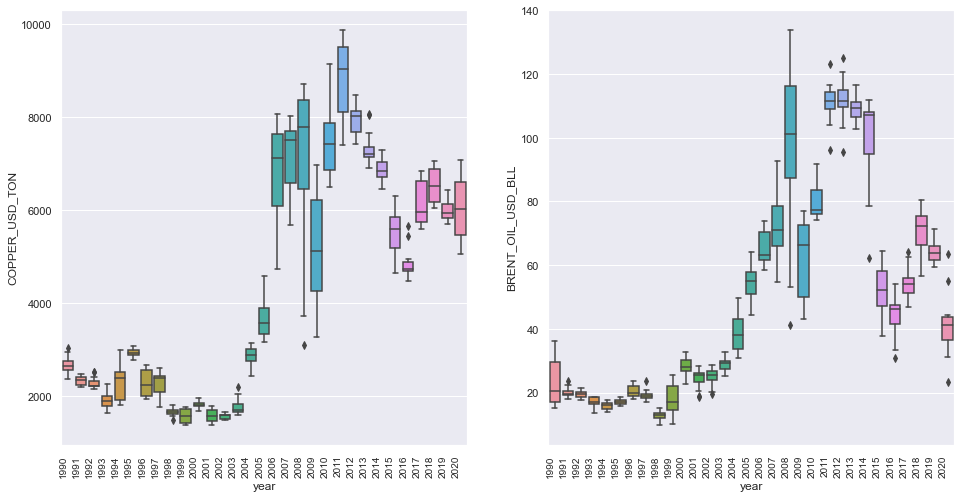

In [11]:
# Box plot of Years Averages

fig,axs = plt.subplots(ncols=2, nrows=1, figsize=(16,8))

axs = axs.ravel()

df['year'] = df.index.year

sns.boxplot(y='COPPER_USD_TON', x='year', ax=axs[0], data=df)
plt.setp(axs[0].get_xticklabels(), rotation = (90), fontsize = 10, ha='right')

sns.boxplot(y='BRENT_OIL_USD_BLL', x='year', ax=axs[1], data=df)
plt.setp(axs[1].get_xticklabels(), rotation = (90), fontsize = 10, ha='right')

plt.plot()

In [25]:
from plotly.subplots import make_subplots

copper_ma = df.COPPER_USD_TON.rolling(12).mean()
oil_ma = df.BRENT_OIL_USD_BLL.rolling(12).mean()

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=copper_ma.index, y=copper_ma.values, name="Copper MA"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=oil_ma.index, y=oil_ma.values, name="Brent Oil MA"),
    row=1, col=2
)

fig.update_layout(height=600, width=800, title_text="Copper and Brent Oil Moving Averages")
fig.show()

- Existe uma tendência de alta nos preços, sobretudo a partir de 2005, que pode ser observada nas duas séries;

- A partir de 2005, observa-se maior volatilidade nos preços anuais, com grande dispersão das distribuições dos preços;

- A partir de 2011, em um "ciclo" menor, existe uma tendência de queda nos preços anuais, mantendo patamares elevados


In [39]:
copper_ma = pd.DataFrame(df.COPPER_USD_TON.rolling(24).mean())
oil_ma = pd.DataFrame(df.BRENT_OIL_USD_BLL.rolling(24).mean())

copper_ma['year'], oil_ma['year'] = copper_ma.index.year, oil_ma.index.year

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Box(y=copper_ma.COPPER_USD_TON, x=copper_ma.year, name="Copper"),
    row=1, col=1
)

fig.add_trace(
    go.Box(y=oil_ma.BRENT_OIL_USD_BLL, x=oil_ma.year, name="Brent Oil"),
    row=1, col=2
)

fig.update_layout(height=400, width=600, title_text="Copper and Brent Oil Box Plot")
fig.show()


## Monthly Seasonality 

[]

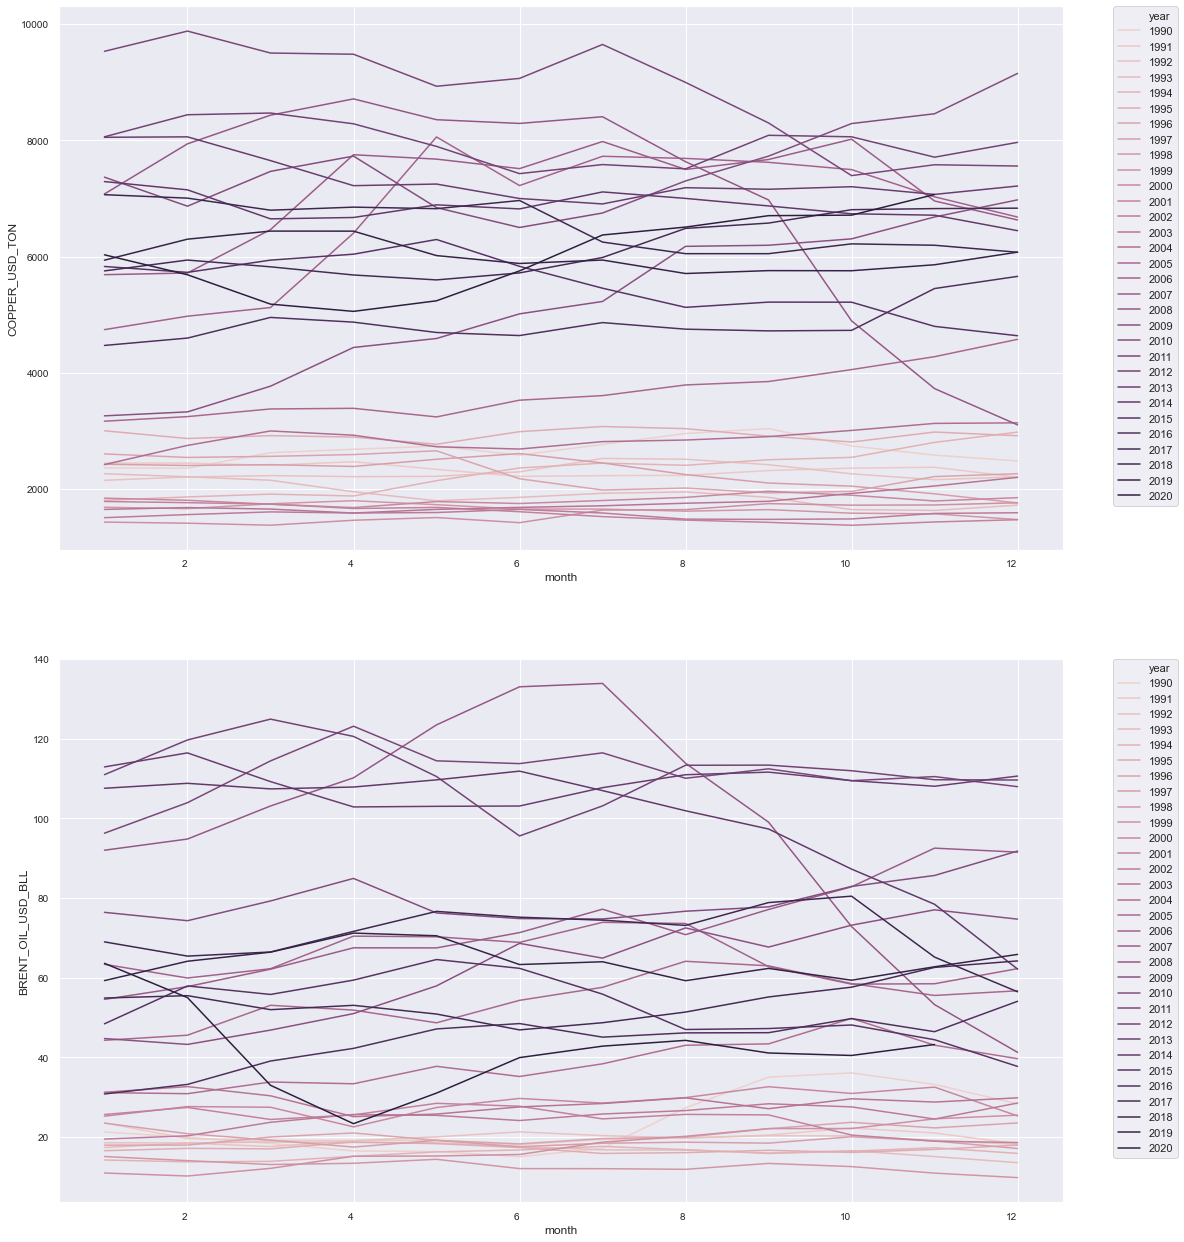

In [54]:
fig,axs = plt.subplots(ncols=1, nrows=2, figsize=(18,22))

axs = axs.ravel()

cols = df.columns.values[:2]

df['month'] = df.index.month

for i, col in enumerate(cols):
    sns.lineplot(data=df, x='month', y=col, hue='year', legend='full', ax=axs[i])
    plt.setp(axs[i].get_xticklabels(), rotation = (0), fontsize = 10, ha='right')
    plt.setp(axs[i].get_yticklabels(), rotation = (0), fontsize = 10, ha='right')
    axs[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
plt.plot()

- Não observa-se padrões de comportamento sazonais de ordem anual. 

In [74]:
fig = go.Figure()

g_year = df.groupby('year', as_index=False).mean()

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['COPPER_USD_TON'],
    name='COPPER_USD_TON'
))

copper_ma = df.COPPER_USD_TON.rolling(12).mean()

fig.add_trace(
    go.Scatter(x=copper_ma.index, y=copper_ma.values, name="Copper MA")
)

fig.update_layout(height=500, width=800)

# Decompose Copper Time Series

- Time Series can be modeled considering four components. Three of these components are systematic (Trend, Seasonality and Level) and one non-systematic component (noise)

- There are different techinques to decompose a time series. The naive approach considers wheter the time series is Multiplicative or Aditive. 

- For the presented analysis the time series are modeled as additive, therefore: 
    * yt = Lt + Tt + St + *noise*. 
    
- (Additive models are linear and the model used here is linear (ARIMA))

```
REFS: 
- Shumeli et al., Pratical Time Series Forecasting with R (Section 2.2 - Time Series Components);
- Athanasopoulos, Forecasting Principals and Practice (Ch. 6.3)
```

## classical/naive decomposition

1. Tt = 2*m-MA, m é par; Tt = m-MA, cc
2. detrendTt = yt-Tt
3. St=mean(detrendTt)
4. noise=yt-Tt-St

### COPPER

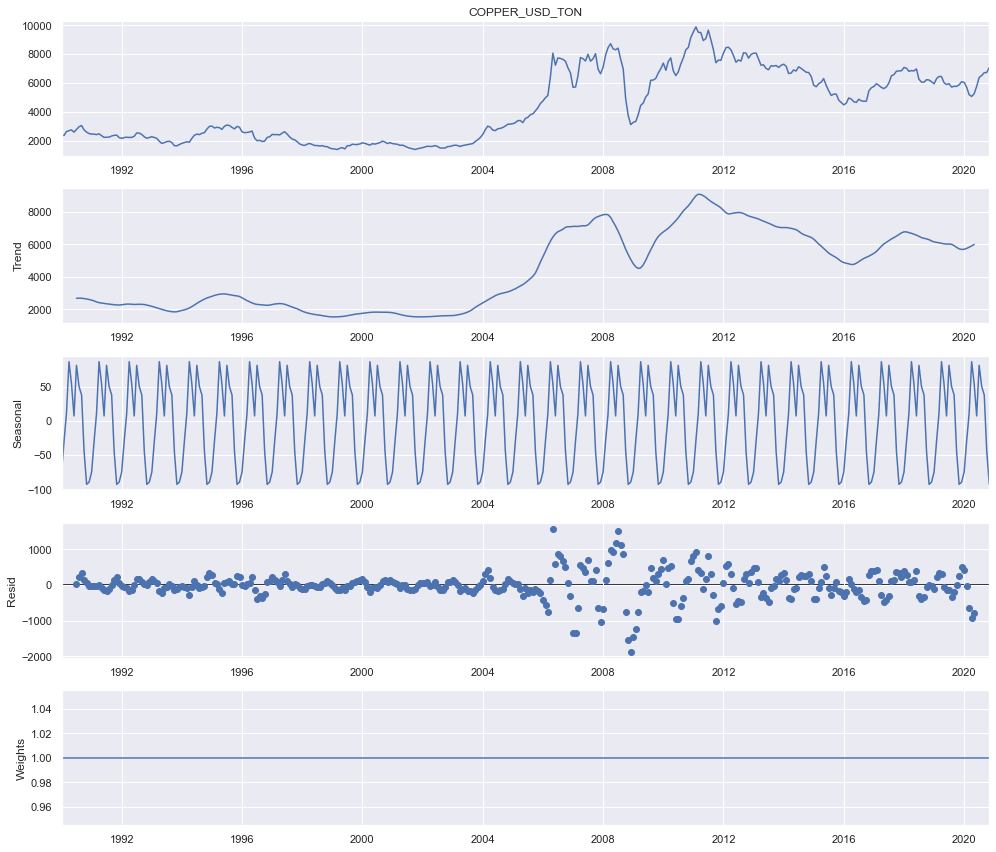

In [96]:
from statsmodels.tsa.seasonal import seasonal_decompose 

d_copper = seasonal_decompose(df.COPPER_USD_TON, model='additive', period=12)

d_copper.plot(weights=True)
plt.rc("figure", figsize=(14,12))
plt.show()

In [107]:
copper_detrend = pd.merge(copper_ma, df.COPPER_USD_TON, left_index=True, right_index=True)
copper_detrend['detrend'] = copper_detrend.COPPER_USD_TON_y - copper_detrend.COPPER_USD_TON_x 

copper_detrend.dropna(inplace=True)

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=copper_detrend.index, y=copper_detrend.detrend, name="Copper MA")
)

In [113]:
copper_detrend = pd.merge(d_copper.trend, df.COPPER_USD_TON, left_index=True, right_index=True)
copper_detrend['detrend'] = copper_detrend.COPPER_USD_TON - copper_detrend.trend 

copper_detrend.dropna(inplace=True)

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=copper_detrend.index, y=copper_detrend.detrend, name="Copper MA")
)

- Grosseiramente:
    * Remoção da tendência, subtraindo a média móvel, com período igual a 12 (anual), da série original. Parte da tendência foi removida.
- Estatisticamente:
    * Remoção da tendência, subtraindo a tendência da série original. Parte da tendência foi removida.


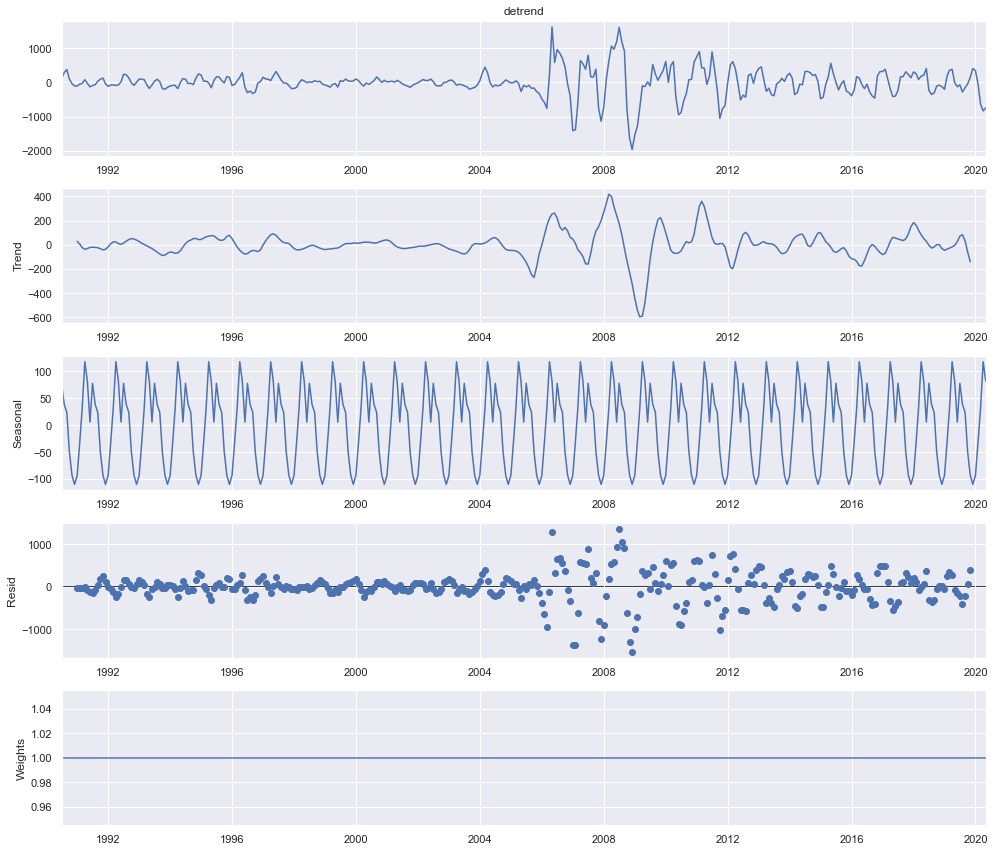

In [114]:
seasonal_decompose(copper_detrend.detrend, model='additive').plot(weights=True)
plt.rc("figure", figsize=(14,12))
plt.show()

In [115]:
cp_detr_ma = copper_detrend.detrend.rolling(12).mean()

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=cp_detr_ma.index, y=cp_detr_ma.values, name="Copper MA")
)

- Sazonalidade: O comportamento da componente sazonal é estranho. Quando analiso a série original, não há evidências de sazonalidade anual, como apresentado na decomposição da série.
    * A metodologia de decomposição clássica, assume que a componente sazonal é simplesmente a média da série sem tendência, o que é uma hipótese fraca.

## Seasonal-Trend Decomposition

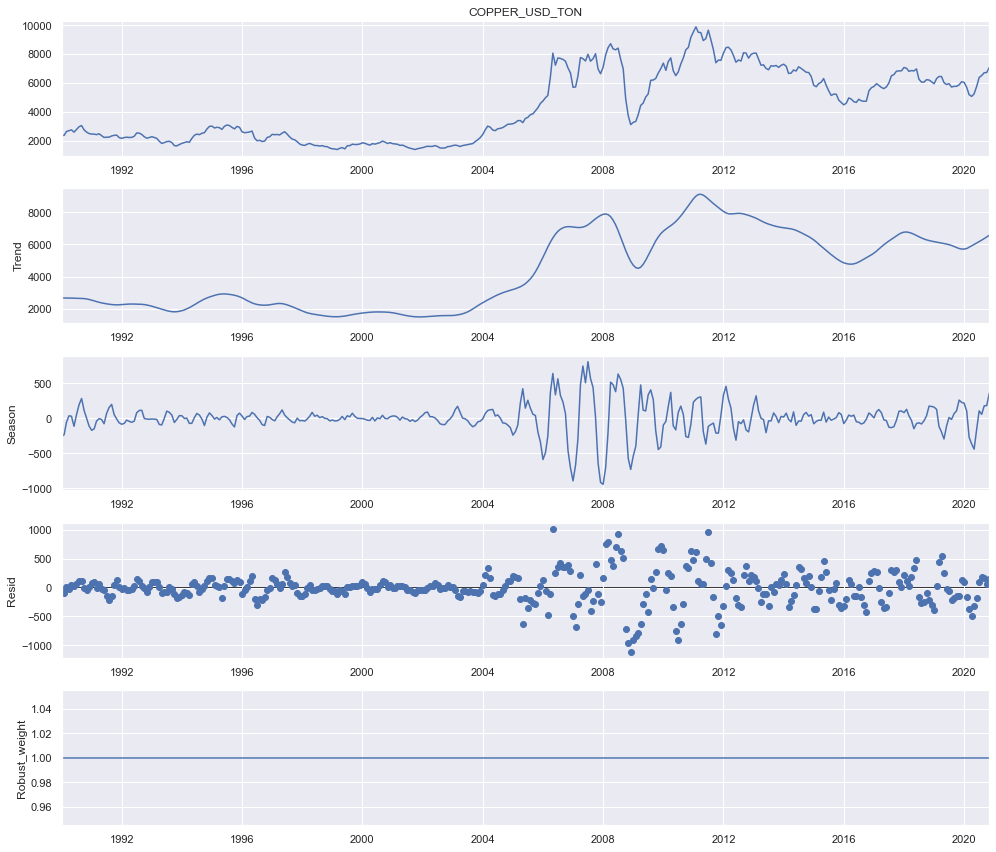

In [116]:
from statsmodels.tsa.seasonal import STL

d_copper_stl = STL(df.COPPER_USD_TON).fit()

d_copper_stl.plot(weights=True)
plt.rc("figure", figsize=(14,12))
plt.show()

[]

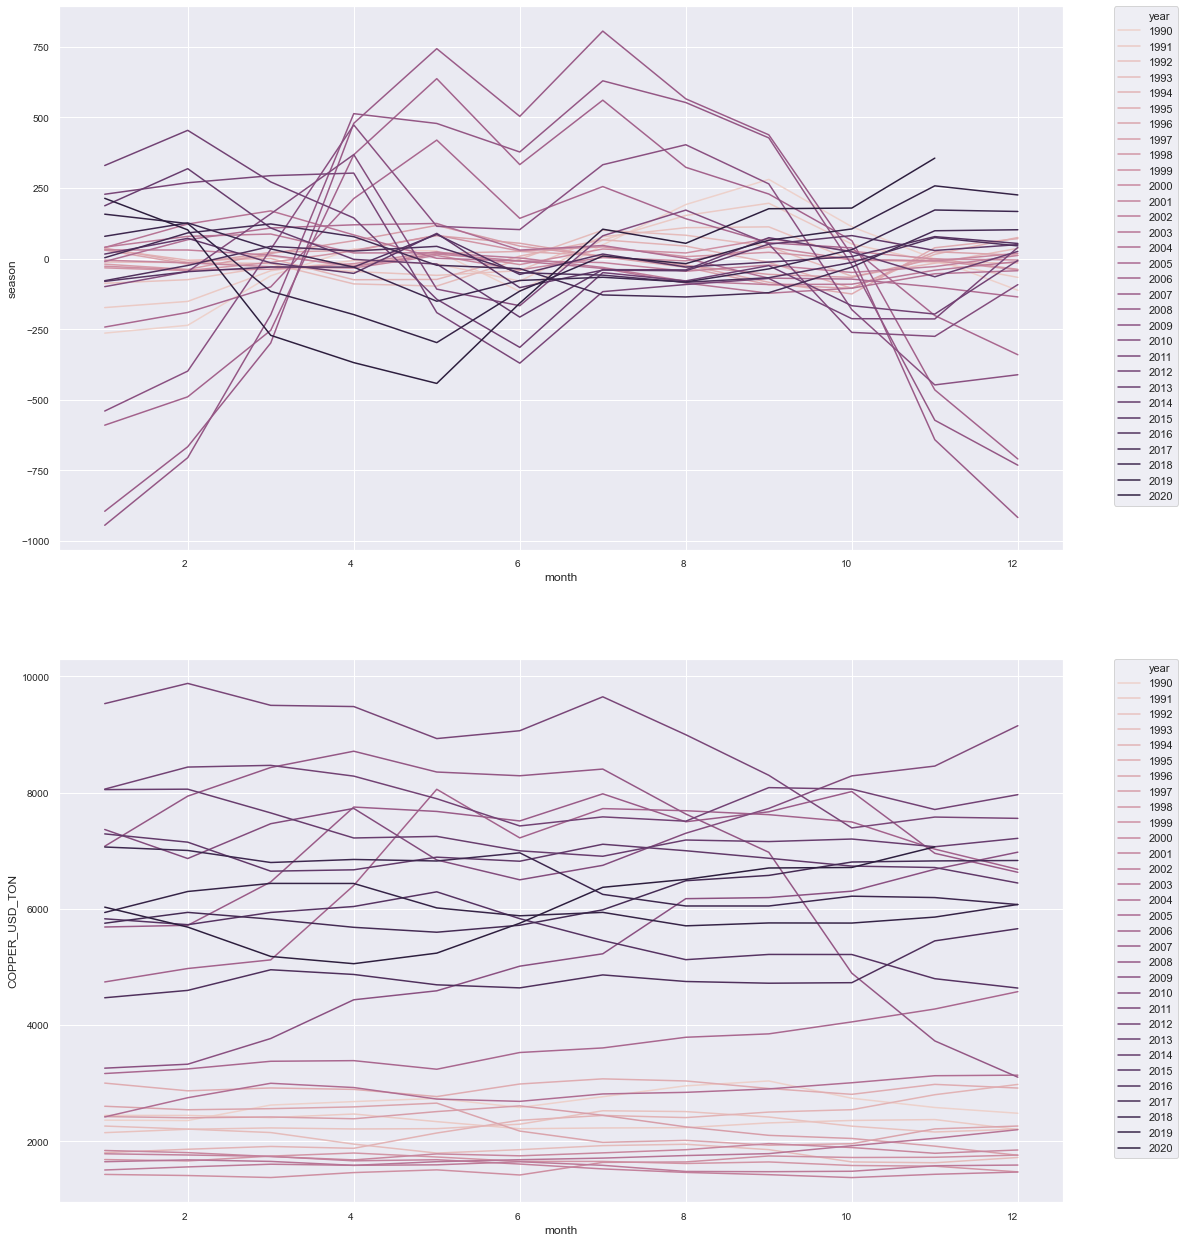

In [129]:
seasonal_copper = pd.merge(d_copper_stl.seasonal, df.COPPER_USD_TON, left_index=True, right_index=True)

seasonal_copper['year'], seasonal_copper['month'] = seasonal_copper.index.year, seasonal_copper.index.month

fig,axs = plt.subplots(ncols=1, nrows=2, figsize=(18,22))
axs = axs.ravel()

for i, col in enumerate(seasonal_copper.columns.values[:2]):
    sns.lineplot(data=seasonal_copper, x='month', y=col, hue='year', legend='full', ax=axs[i], color='red')
    plt.setp(axs[i].get_xticklabels(), rotation = (0), fontsize = 10, ha='right')
    plt.setp(axs[i].get_yticklabels(), rotation = (0), fontsize = 10, ha='right')
    axs[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
plt.plot()

### BRENT OIL

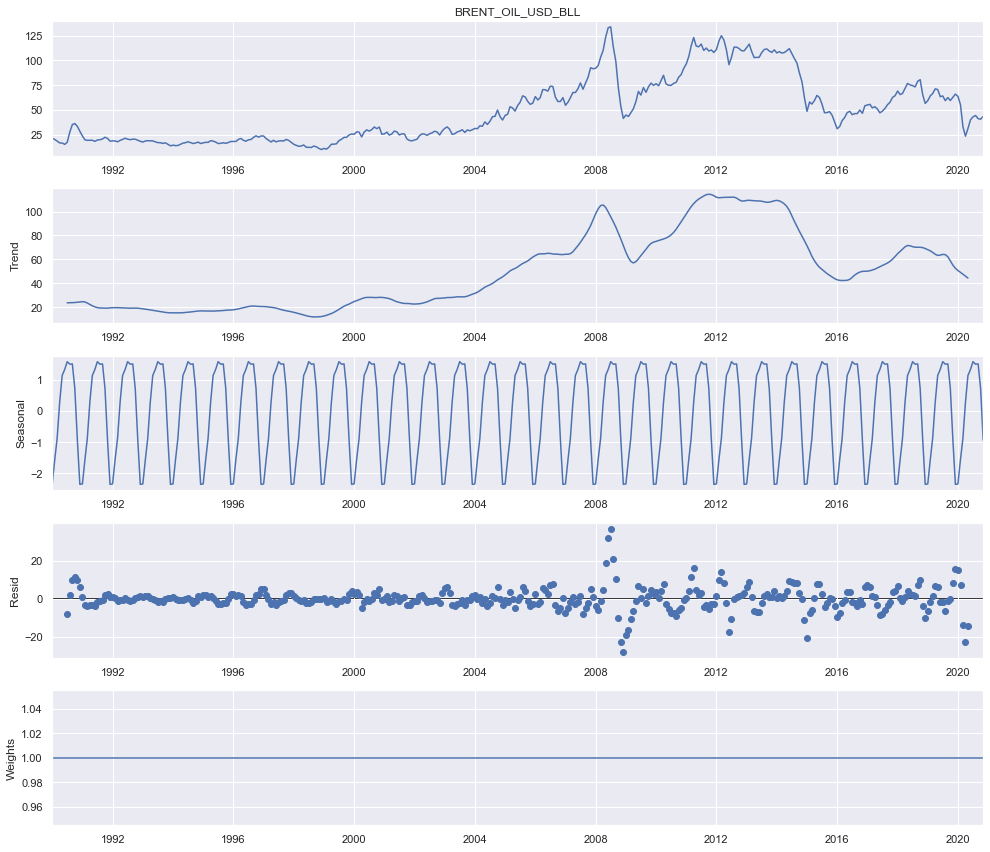

In [100]:
d_oil = seasonal_decompose(df.BRENT_OIL_USD_BLL, model='additive')

d_oil.plot(weights=True)
plt.rc("figure", figsize=(14,12))
plt.show()

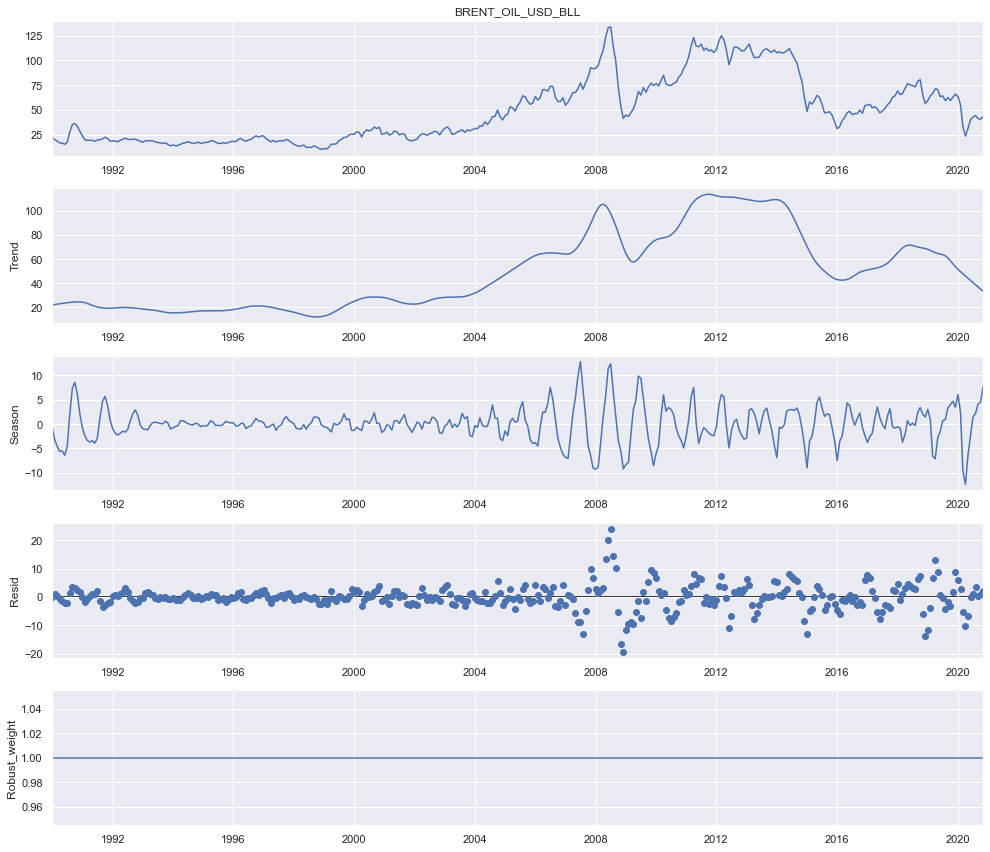

In [130]:
d_oil_stl = STL(df.BRENT_OIL_USD_BLL).fit()

d_oil_stl.plot(weights=True)
plt.rc("figure", figsize=(14,12))
plt.show()

[]

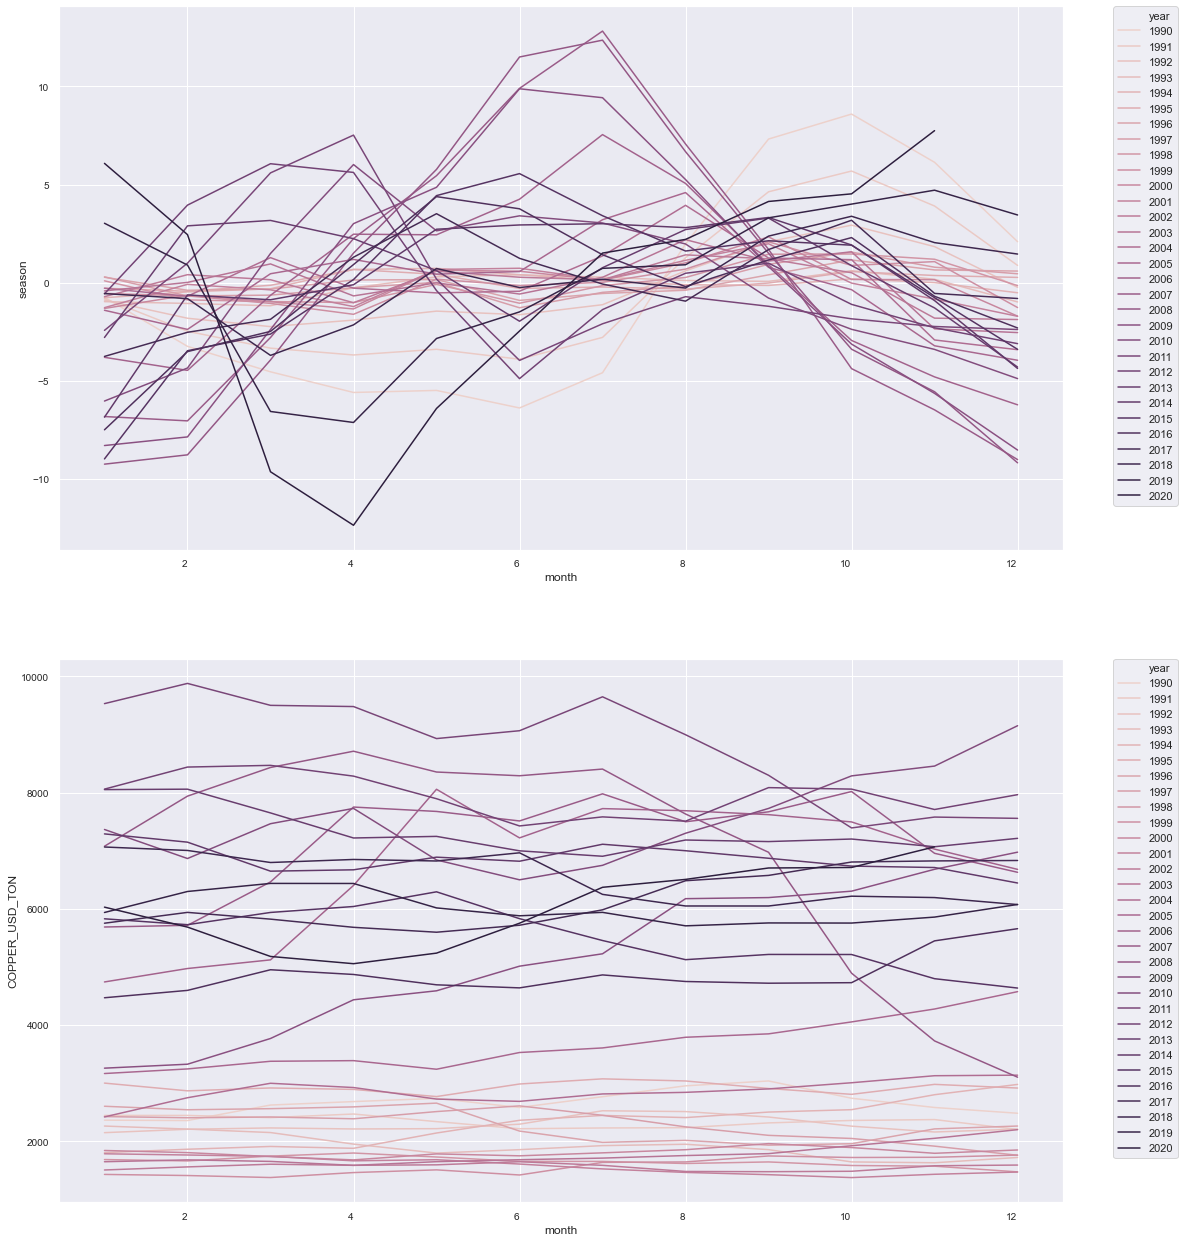

In [131]:
seasonal_oil = pd.merge(d_oil_stl.seasonal, df.COPPER_USD_TON, left_index=True, right_index=True)

seasonal_oil['year'], seasonal_oil['month'] = seasonal_oil.index.year, seasonal_oil.index.month

fig,axs = plt.subplots(ncols=1, nrows=2, figsize=(18,22))
axs = axs.ravel()

for i, col in enumerate(seasonal_oil.columns.values[:2]):
    sns.lineplot(data=seasonal_oil, x='month', y=col, hue='year', legend='full', ax=axs[i], color='red')
    plt.setp(axs[i].get_xticklabels(), rotation = (0), fontsize = 10, ha='right')
    plt.setp(axs[i].get_yticklabels(), rotation = (0), fontsize = 10, ha='right')
    axs[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
plt.plot()

# Testes de Estacionariedade